# 0 - Arbitrage Transaction Analysis
This notebook solely analyzes some given arbitrage transactions on Ethereum. It is independent of the notebook series that starts from 1.

See the [log file](arb_tx_data\0xe976f2ebd70135153e8522c3aaa3c9d489717ef621d69b9e00a9f215d0474918\log.txt) for the tx. For analysis purpose, swaps are grouped together if they form a cyclic arbitrage.

In [1]:
# Standard Library
from pprint import pprint

# Third Party Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local Folder Library
from pyammanalysis.amm_arb import UniV2Scraper, UniV3Scraper, graph_arbitrage
from pyammanalysis.subgraph import *
from pyammanalysis.util import *

In [2]:
TX_QUERY = """
{
    transaction(id: "0xe976f2ebd70135153e8522c3aaa3c9d489717ef621d69b9e00a9f215d0474918") {
        blockNumber
        timestamp
        gasUsed
        gasPrice
        swaps {
            pool {
                feeTier
            }
            token0 {
                symbol
            }
            token1 {
                symbol
            }
        }
    }
}
"""

In [3]:
arb_tx_result = run_query(UNISWAP_V3_SUBGRAPH_URL, TX_QUERY)["transaction"]
block_number = int(arb_tx_result["blockNumber"])  # 14931986
pprint(arb_tx_result)

{'blockNumber': '14931986',
 'gasPrice': '24195653806',
 'gasUsed': '1405319',
 'swaps': [{'pool': {'feeTier': '3000'},
            'token0': {'symbol': 'erowan'},
            'token1': {'symbol': 'USDT'}},
           {'pool': {'feeTier': '10000'},
            'token0': {'symbol': 'WETH'},
            'token1': {'symbol': 'MTO'}},
           {'pool': {'feeTier': '10000'},
            'token0': {'symbol': 'RSR'},
            'token1': {'symbol': 'WETH'}}],
 'timestamp': '1654768688'}


## Profitability of Group 5 Tx
Cyclic arbitrage of 3 pools on Uniswap V2:
```
// group 5: ETH -> ALBT -> 5GS -> ETH, Uniswap V2 => earns ETH
Swap 0.078344525103934434 Ether         For 1,754.673155155967912284 ALBT       On Uniswap V2
Swap 1,754.673155155967912284 ALBT      For 6,645.694535765537281985 GS         On Uniswap V2
Swap 6,645.694535765537281985 GS        For 0.082361461143867988 Ether          On Uniswap V2
```

In [4]:
v2_scraper = UniV2Scraper(block_number)
result = v2_scraper.tx_query()
# result

In [5]:
# note: only prices of pairs in the cyclic arbitrage are filled in
v2_adj_matrix = v2_scraper.create_adj_matrix(
    "data/univ2_adj_matrix.csv", pairs=result["pairs"], tokens=result["tokenSymbols"]
)
v2_adj_matrix.astype(np.float64)  # for display purpose

C:\Users\user\Documents\GitHub\eth-uniswap-prelim-analysis\pyammanalysis\amm_arb\uniswapv2_scraper.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[token1][token0] = pair["token0Price"]
C:\Users\user\Documents\GitHub\eth-uniswap-prelim-analysis\pyammanalysis\amm_arb\uniswapv2_scraper.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[token0][token1] = pair["token1Price"]


,JRT,LMT,WETH,USDT,RSR,STND,LSS,MTO,GS,ALN,LYM,ALBT
JRT,NaN,NaN,78594.094798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.108325,NaN
WETH,0.000013,NaN,NaN,NaN,0.000007,0.000044,0.000195,0.000039,0.000013,0.000008,NaN,0.000045
USDT,NaN,NaN,NaN,NaN,NaN,NaN,0.206978,NaN,NaN,NaN,NaN,NaN
RSR,NaN,NaN,149738.477824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STND,NaN,NaN,22754.890775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LSS,NaN,NaN,5122.564736,4.831425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTO,NaN,NaN,25822.596103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GS,NaN,NaN,77892.163923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.474785
ALN,NaN,NaN,129280.086148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
graph_arbitrage.find_arbitrage(filename="data/univ2_adj_matrix.csv", find_all=True)

ARBITRAGE FOUND

Path: ['WETH', 'GS', 'ALBT', 'WETH']
1.9%



[['WETH', 'GS', 'ALBT', 'WETH']]

## Duration of Arbitrage Opportunity of Group 2 Tx
Next we analyze how long an arbitrage opportunity can last before it is closed by arbitrageurs. We plot the prices of MTO (in terms of ETH) in the two exchanges within 10 blocks of the arbitrage transaction. We also query if there are other tx that involves the same pools.

ETH/MTO mispricing between Uniswap V2 and V3:
```
Swap 0.030101763356738056 Ether         For 1,197.870683638451780146 MTO        On Uniswap V2
Swap 1,197.869482259909079957 MTO       For 0.033130533788874408 Ether          On Uniswap V3
```

In [7]:
v3_g2_scraper = UniV3Scraper(block_number)
result = v3_g2_scraper.tx_query()
# result

In [8]:
v2_eth_mto_addr = "0xc2f02caa6bcac59944912a1446365c4d9c16cc97"
v3_eth_mto_addr = "0x60a6b23a7a87c5ce9e3f81c869691f784b18a704"


def v2_pool_prices_fragment(block_number):
    return (
        'pair(id: "0xc2f02caa6bcac59944912a1446365c4d9c16cc97", block: {number: '
        + str(block_number)
        + "}) {token1Price}"
    )


def v3_pool_prices_fragment(block_number):
    return (
        'pool(id: "0x60a6b23a7a87c5ce9e3f81c869691f784b18a704", block: {number: '
        + str(block_number)
        + "}) {token1Price}"
    )

In [9]:
df = pd.DataFrame()

block_range = np.arange(block_number - 9000, block_number + 600, 100, dtype=int)
df["block_number"] = block_range

batched_query = " ".join(
    [f"blk_{str(block)}: {v2_pool_prices_fragment(block)}" for block in block_range]
)
df["v2_eth_price"] = np.array(
    list(
        map(lambda x: x["token1Price"], v2_scraper.scrape_batch(batched_query).values())
    ),
    dtype=np.float64,
)
batched_query = " ".join(
    [f"blk_{str(block)}: {v3_pool_prices_fragment(block)}" for block in block_range]
)
df["v3_eth_price"] = np.array(
    list(
        map(
            lambda x: x["token1Price"],
            v3_g2_scraper.scrape_batch(batched_query).values(),
        )
    ),
    dtype=np.float64,
)

df.head()

,block_number,v2_eth_price,v3_eth_price
0,14922986,40613.121417,31649.313132
1,14923086,40613.121417,31649.313132
2,14923186,40613.121417,31649.313132
3,14923286,40613.121417,31649.313132
4,14923386,40613.121417,31649.313132


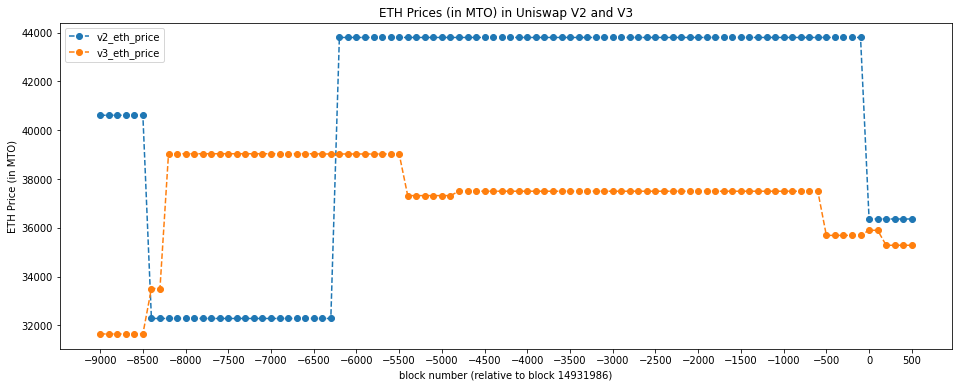

In [10]:
rel_block_number = df["block_number"] - block_number

plt.figure(figsize=(16, 6))
for key in ["v2_eth_price", "v3_eth_price"]:
    plt.plot(rel_block_number, df[key], "--o", label=key)
plt.xticks(rel_block_number[::5])  # xtick every 5 block number queried
plt.title("ETH Prices (in MTO) in Uniswap V2 and V3")
plt.xlabel("block number (relative to block 14931986)")
plt.ylabel("ETH Price (in MTO)")
plt.legend()
plt.show()